# Imports

In [1]:
# standard library imports
# /

# related third party imports
import structlog

# local application/library specific imports
from tools.configurator import (
    get_configs_out,
    get_config_ids,
)
from tools.analyzer import (
    print_table_from_dict,
    print_df_from_dict,
    get_results_dict,
    merge_all_results,
    create_config_id_print,
    get_config_df,
    get_llm_student_preds,
)
from tools.plotter import (
    plot_llm_student_confusion,
    plot_kt_confusion,
    plot_level_correctness,
)


logger = structlog.get_logger(__name__)

/home/abthuy/Documents/PhD research/LLM-virtual-pretesting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##### INPUTS #####
EXP_NAME = (
    # "replication_gemini_20250628-091441"
    # "replication_sonnet_20250629-084225"
    # "replication_ollama_gemma_20250628-142438"
    # "replication_ollama_qwen_20250627-164511"
    # "replication_o3_o4_20250628-143855"
    # "replication_cloud_others_20250624-184518"
    # "replication_ollama_20250624-210701"
    # "replication_cloud_20250624-155854"
    # "replication_ollama_20250624-133329"
    # "replication_misconceptions_20250806-170742"
    # "replication_misconceptions_tryout_20250807-152718"
    "replication_misconceptions_20250808-171245"
)
EXCLUDE_METRICS = [
    "val_acc_true_student",
    "val_acc_true_pred",
    "val_f1_true_student",
    "val_f1_true_pred",
    "val_f1_student_pred",
    "val_f1_kt",
]
LEGEND_EXACT = True

In [3]:
METRIC2LEGEND_DICT = {
    "val_acc_student_pred": "val acc",
    "val_acc_true_student": "val acc student -> true",
    "val_acc_true_pred": "val acc LLM -> true",
    "val_f1_student_pred": "val f1 LLM -> student",
    "val_f1_true_student": "val f1 student -> true",
    "val_f1_true_pred": "val f1 LLM -> true",
    "val_acc_kt": "val acc (KT)",
    "val_f1_kt": "val f1 LLM -> student (KT)",
    "val_prop_invalid": "val prop invalid",
}

In [4]:
configs = get_configs_out(EXP_NAME)
config_ids = get_config_ids(configs)
config_dict = {config_id: cfg for config_id, cfg in zip(config_ids, configs)}

CONFIG2LEGEND_DICT = {
    config_id: create_config_id_print(config_id) for config_id in config_ids
}
legend_kwargs = {
    "config2legend": CONFIG2LEGEND_DICT,
    "legend_exact": LEGEND_EXACT,
    "metric2legend": METRIC2LEGEND_DICT,
}

In [5]:
# merge results for all configs
run_id_dict = merge_all_results(EXP_NAME, config_ids)

2025-08-11 08:21:23 [info     ] Merging runs [1, 2] in: output/replication_misconceptions_20250808-171245/o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random3.pickle
2025-08-11 08:21:23 [info     ] Saving data                    path=output
2025-08-11 08:21:23 [info     ] Merging runs [1, 2] in: output/replication_misconceptions_20250808-171245/o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact3.pickle
2025-08-11 08:21:23 [info     ] Saving data                    path=output
2025-08-11 08:21:23 [info     ] Merging runs [1, 2] in: output/replication_misconceptions_20250808-171245/o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact10.pickle
2025-08-11 08:21:23 [info     ] Saving data                    path=output
2025-08-11 08:21:23 [info     ] Merging runs [1, 2] in: out

# Val/Test set performance

In [6]:
results_dict = get_results_dict(
    exp_name=EXP_NAME,
    config_ids=config_ids,
    run_id=None,
)
# # NOTE: print paper-like table with this code
# print_table_from_dict(
#     eval_dict=results_dict,
#     exp_name=EXP_NAME,
#     exclude_metrics=EXCLUDE_METRICS,
#     decimals=3,
#     **legend_kwargs,
# )

2025-08-11 08:21:23 [info     ] Loading checkpoint             output_path=output/replication_misconceptions_20250808-171245/o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random3.pickle
2025-08-11 08:21:23 [info     ] Loading checkpoint             output_path=output/replication_misconceptions_20250808-171245/o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact3.pickle
2025-08-11 08:21:23 [info     ] Loading checkpoint             output_path=output/replication_misconceptions_20250808-171245/o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact10.pickle
2025-08-11 08:21:23 [info     ] Loading checkpoint             output_path=output/replication_misconceptions_20250808-171245/o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_zero_studentlevel~EFI_quotes~E

In [7]:
# NOTE: print dataframe
df = print_df_from_dict(
    eval_dict=results_dict,
    exp_name=EXP_NAME,
    exclude_metrics=EXCLUDE_METRICS,
    **legend_kwargs,
    # save=True,
    # save_kwargs={"fname": os.path.join("output", EXP_NAME, "results.csv")},
)

df_config = get_config_df(config_dict)

df_mean = df.xs("mean", axis=1, level=1, drop_level=True)
df_results = df_mean.merge(df_config, how="left", on="config_id")
df_results = df_results.reindex(
    columns=(
        list(df_config.columns)
        + list([a for a in df_mean.columns if a not in df_config.columns])
    )
)
df_results

,config_id,model,temp,struc_output,prompt,example_selec,num_examples,val acc,val prop invalid,val acc (KT),val_monotonicity
0,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_random,3,0.605,0.0,0.670,0.483304
1,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,3,0.640,0.0,0.710,0.807945
2,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,10,0.625,0.0,0.685,0.514532
3,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_zero_studentlevel,miscon_studentid_random,0,0.585,0.0,0.665,0.614156
4,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,10,0.595,0.0,0.660,0.197314
5,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_random,10,0.615,0.0,0.685,0.494180
6,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,5,0.615,0.0,0.670,0.182998
7,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_random,5,0.630,0.0,0.690,0.627956
8,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_random,1,0.610,0.0,0.680,0.342913
9,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,5,0.600,0.0,0.675,0.633015


In [ ]:
# standard error
df_stderr = df.xs("stderr", axis=1, level=1, drop_level=True)
df_results = df_stderr.merge(df_config, how="left", on="config_id")
df_results = df_results.reindex(
    columns=(
        list(df_config.columns)
        + list([a for a in df_stderr.columns if a not in df_config.columns])
    )
)
df_results

,config_id,model,temp,struc_output,prompt,example_selec,num_examples,val acc,val prop invalid,val acc (KT),val_monotonicity
0,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_random,3,0.005,0.0,0.010,0.048529
1,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,3,0.030,0.0,0.010,0.118970
2,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,10,0.005,0.0,0.005,0.015844
3,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_zero_studentlevel,miscon_studentid_random,0,0.025,0.0,0.005,0.062222
4,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,10,0.015,0.0,0.010,0.291264
5,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_random,10,0.025,0.0,0.025,0.098511
6,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,5,0.015,0.0,0.000,0.634283
7,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_random,5,0.020,0.0,0.010,0.010462
8,o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,0.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_random,1,0.010,0.0,0.010,0.237663
9,o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_re...,o4-mini-2025-04-16,1.0,student_bool,replicate_student_chocolate_studentlevel,miscon_studentid_kc_exact,5,0.010,0.0,0.005,0.073836


In [8]:
# inspect average performance per config value
FEATURE = "num_examples"
df_results.groupby(FEATURE).agg({"val acc": "mean", "val acc (KT)": "mean", "val_monotonicity": "mean"}).round(3)

,val acc,val acc (KT),val_monotonicity
num_examples,,,
0,0.612,0.682,0.596
1,0.614,0.676,0.101
3,0.628,0.694,0.434
5,0.612,0.675,0.434
10,0.609,0.675,0.398


In [9]:
# inspect average performance per config value
FEATURE = "model"
df_results.groupby(FEATURE).agg({"val acc": "mean", "val acc (KT)": "mean", "val_monotonicity": "mean"}).round(3)

,val acc,val acc (KT),val_monotonicity
model,,,
o4-mini-2025-04-16,0.615,0.68,0.37


In [10]:
# inspect average performance per config value
FEATURE = "temp"
df_results.groupby(FEATURE).agg({"val acc": "mean", "val acc (KT)": "mean", "val_monotonicity": "mean"}).round(3)

,val acc,val acc (KT),val_monotonicity
temp,,,
0.0,0.613,0.679,0.374
1.0,0.617,0.682,0.366


In [11]:
# inspect average performance per config value
FEATURE = "prompt"
df_results.groupby(FEATURE).agg({"val acc": "mean", "val acc (KT)": "mean", "val_monotonicity": "mean"}).round(3)

,val acc,val acc (KT),val_monotonicity
prompt,,,
replicate_student_chocolate_studentlevel,0.616,0.680,0.342
replicate_student_chocolate_zero_studentlevel,0.612,0.682,0.596


In [12]:
# inspect average performance per config value
FEATURE = "num_examples"
df_results.groupby(FEATURE).agg({"val acc": "mean", "val acc (KT)": "mean", "val_monotonicity": "mean"}).round(3)

,val acc,val acc (KT),val_monotonicity
num_examples,,,
0,0.612,0.682,0.596
1,0.614,0.676,0.101
3,0.628,0.694,0.434
5,0.612,0.675,0.434
10,0.609,0.675,0.398


In [13]:
# inspect average performance per config value
FEATURE = "example_selec"
df_results.groupby(FEATURE).agg({"val acc": "mean", "val acc (KT)": "mean", "val_monotonicity": "mean"}).round(3)

,val acc,val acc (KT),val_monotonicity
example_selec,,,
miscon_studentid_kc_exact,0.616,0.682,0.330
miscon_studentid_random,0.615,0.678,0.402


# Confusion matrices
## LLM vs student performance

In [14]:
# # single config
# config_id = "qwen3:8b~T_0.0~SO_teacher~SP_replicate_teacher_avocado~EF_quotes~ES_studentid_random3"  # TODO
# if config_id not in config_ids:
#     logger.error(f"Config ID not available", config_id=config_id)
# else:
#     preds_dict = get_llm_student_preds(
#         exp_name=EXP_NAME,
#         config_id=config_id,
#         run_id=1,
#         split="val",
#     )
#     plot_llm_student_confusion(
#         preds_dict,
#         config_id=config_id,
#         normalize="all",
#     )


2025-08-11 08:21:23 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random3 run_id=1 split=val


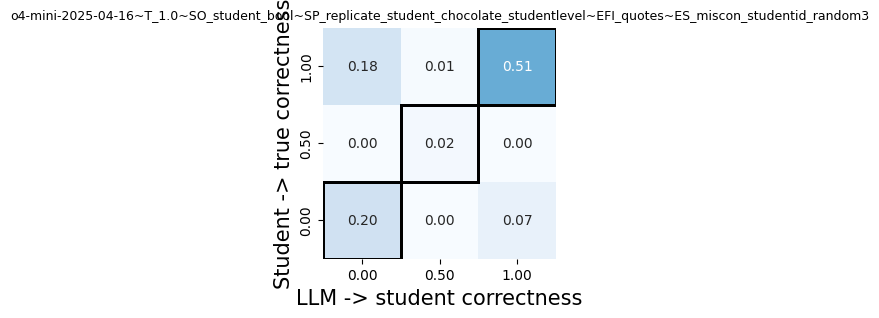

2025-08-11 08:21:23 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact3 run_id=1 split=val


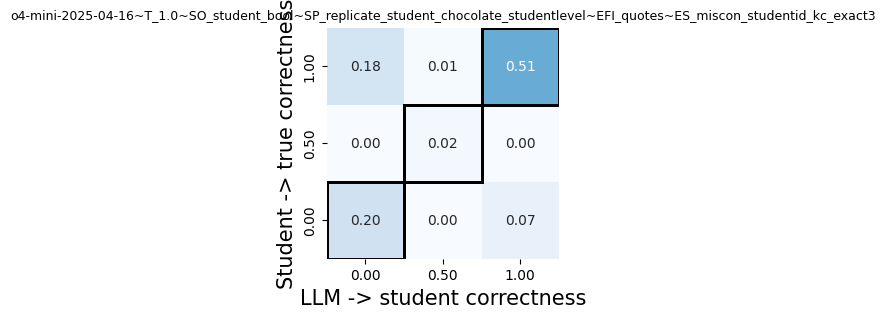

2025-08-11 08:21:24 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact10 run_id=1 split=val


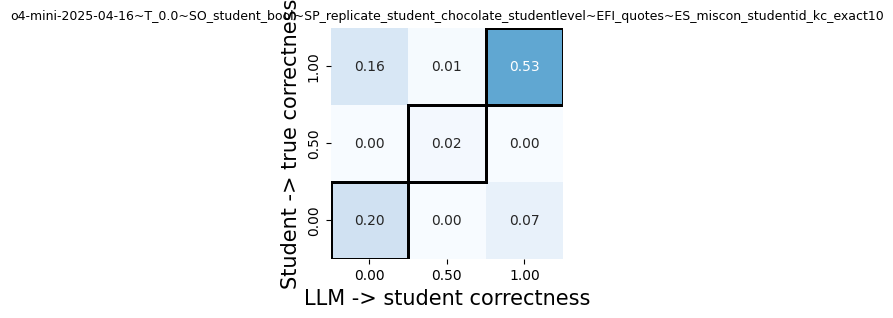

2025-08-11 08:21:24 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_zero_studentlevel~EFI_quotes~ES_miscon_studentid_random0 run_id=1 split=val


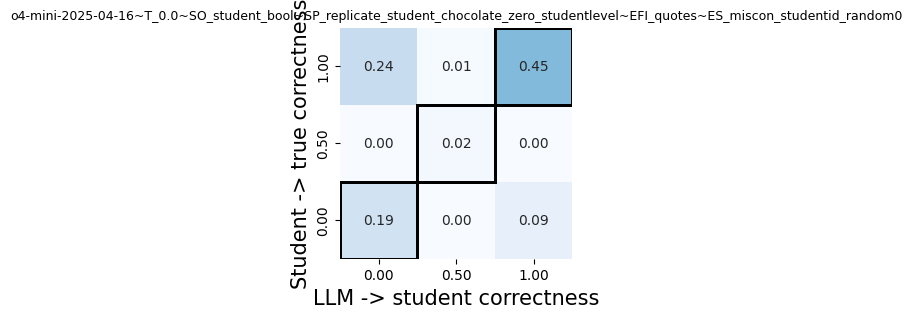

2025-08-11 08:21:24 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact10 run_id=1 split=val


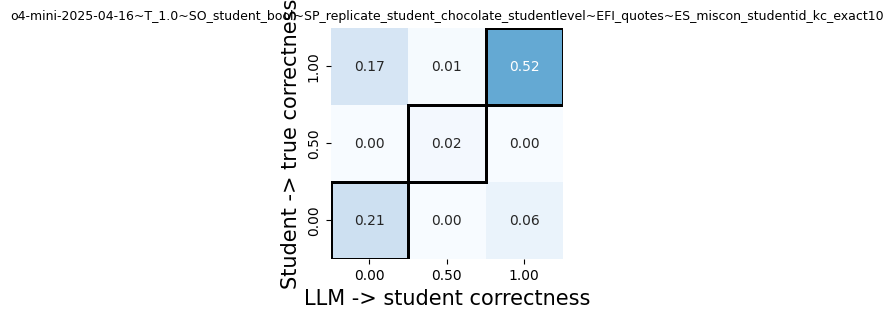

2025-08-11 08:21:24 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random10 run_id=1 split=val


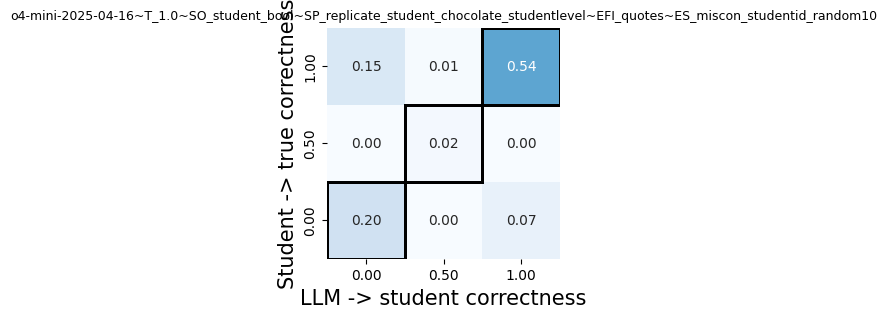

2025-08-11 08:21:24 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact5 run_id=1 split=val


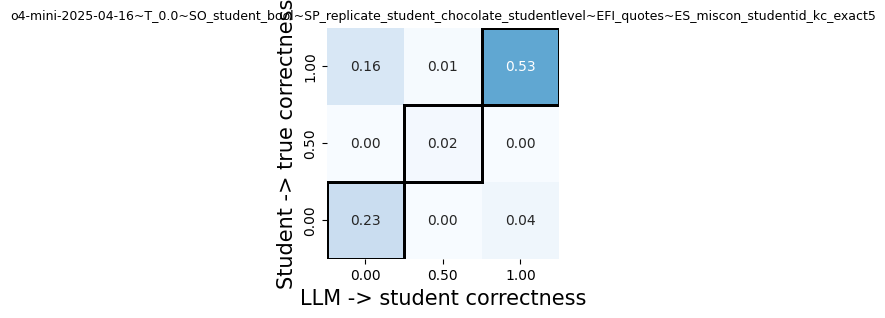

2025-08-11 08:21:24 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random5 run_id=1 split=val


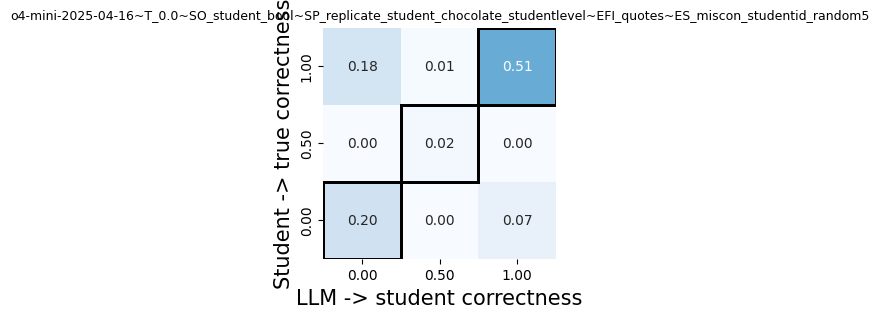

2025-08-11 08:21:24 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random1 run_id=1 split=val


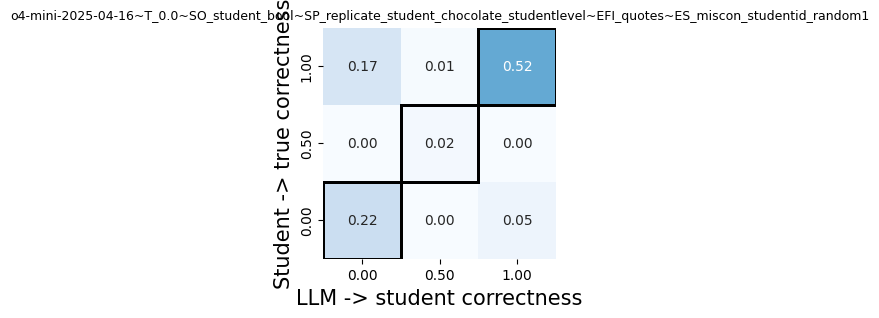

2025-08-11 08:21:25 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact5 run_id=1 split=val


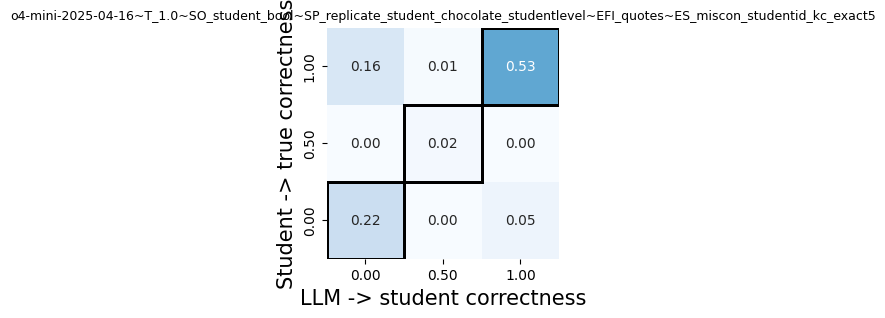

2025-08-11 08:21:25 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random1 run_id=1 split=val


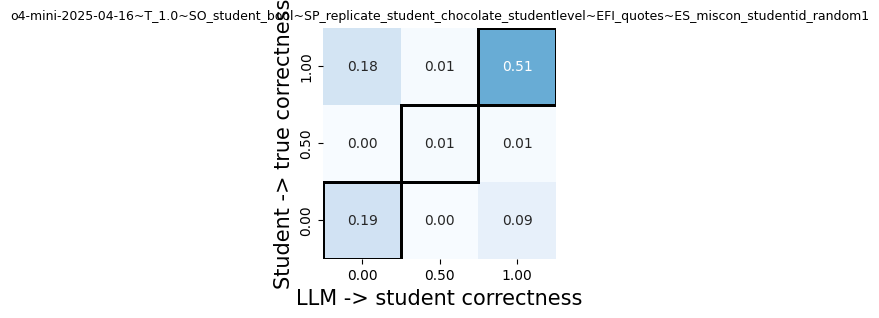

2025-08-11 08:21:25 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact1 run_id=1 split=val


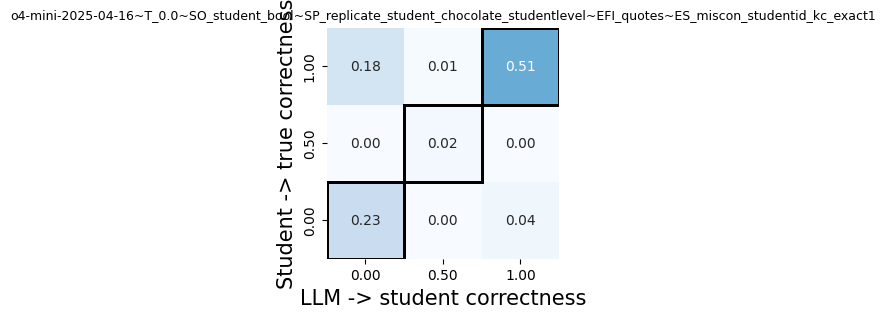

2025-08-11 08:21:25 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact3 run_id=1 split=val


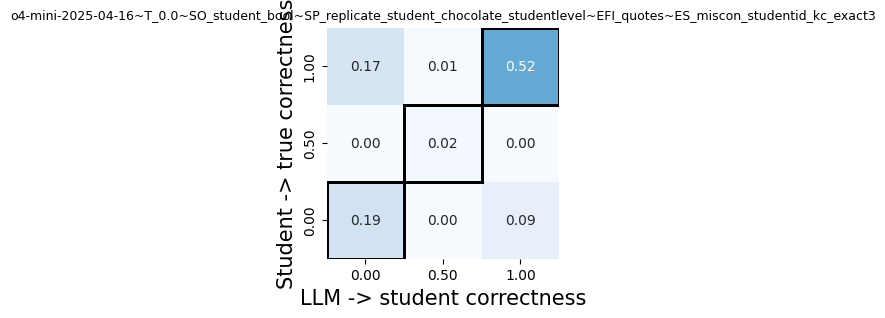

2025-08-11 08:21:25 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact1 run_id=1 split=val


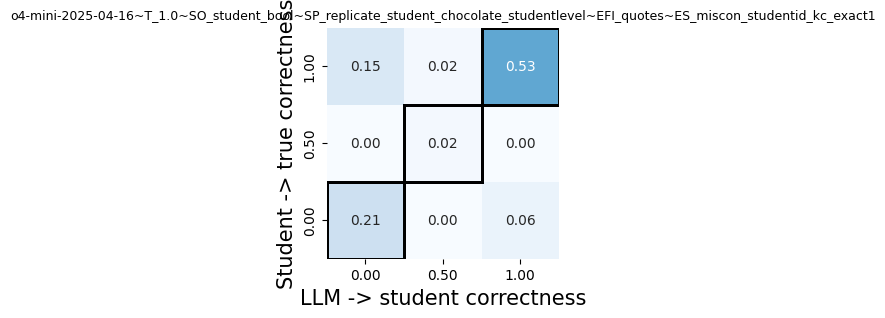

2025-08-11 08:21:25 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random3 run_id=1 split=val


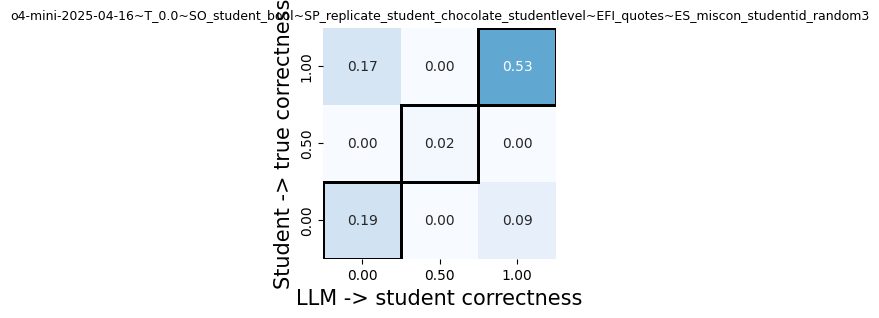

2025-08-11 08:21:25 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random5 run_id=1 split=val


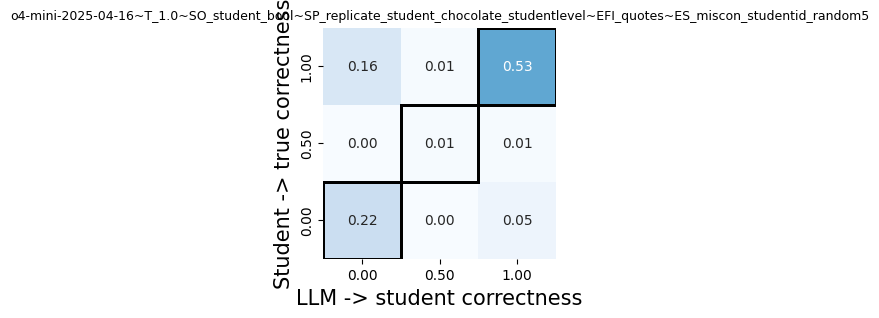

2025-08-11 08:21:26 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random10 run_id=1 split=val


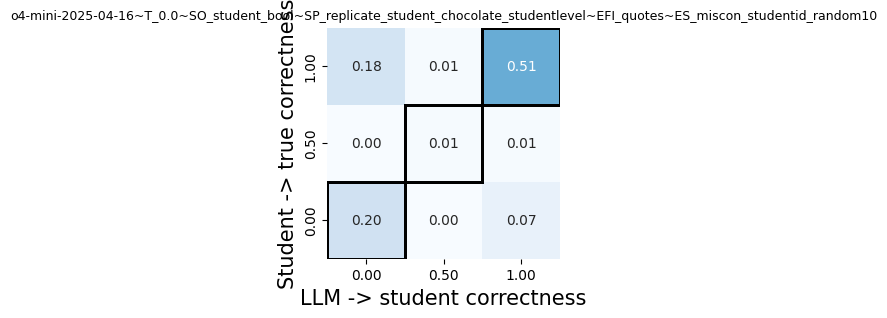

2025-08-11 08:21:26 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_zero_studentlevel~EFI_quotes~ES_miscon_studentid_random0 run_id=1 split=val


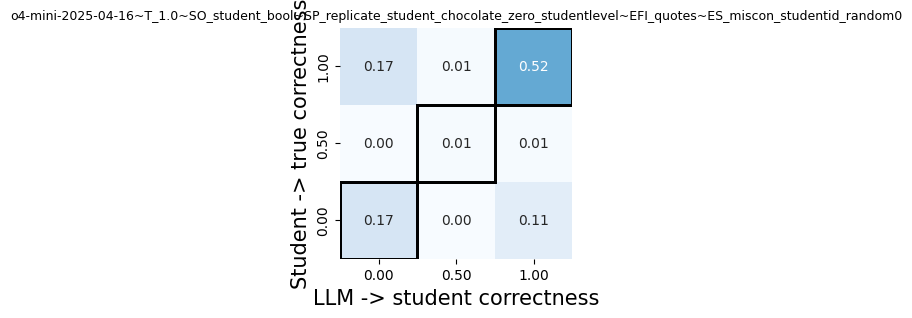

In [15]:
# all configs
for config_id in config_ids:
    preds_dict = get_llm_student_preds(
        exp_name=EXP_NAME,
        config_id=config_id,
        run_id=1,
        split="val",
    )
    plot_llm_student_confusion(
        preds_dict,
        config_id=config_id,
        normalize="all",
    )

## KT

2025-08-11 08:21:26 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random3 run_id=1 split=val


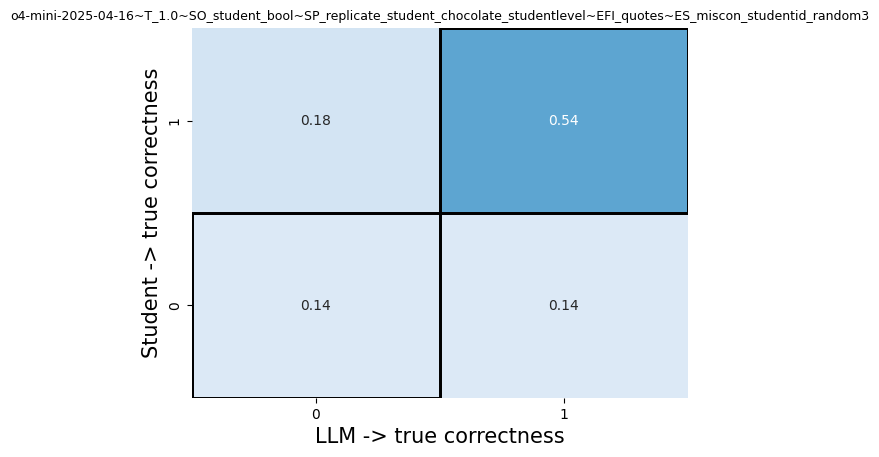

2025-08-11 08:21:26 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact3 run_id=1 split=val


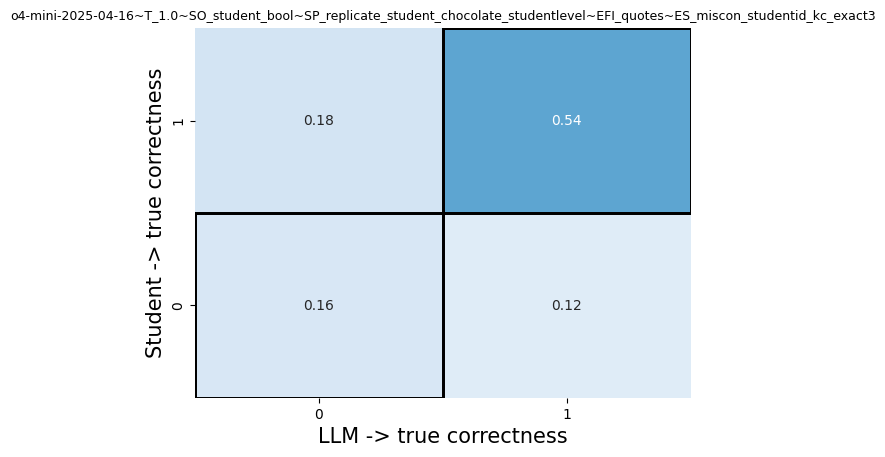

2025-08-11 08:21:26 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact10 run_id=1 split=val


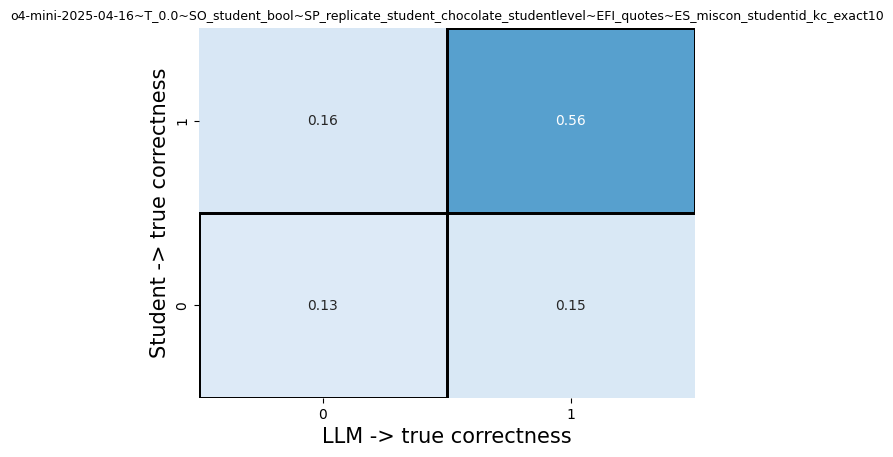

2025-08-11 08:21:26 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_zero_studentlevel~EFI_quotes~ES_miscon_studentid_random0 run_id=1 split=val


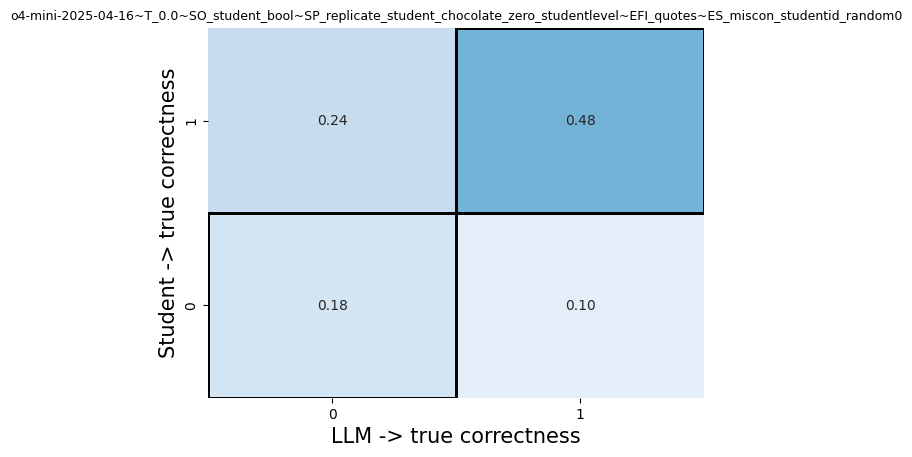

2025-08-11 08:21:26 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact10 run_id=1 split=val


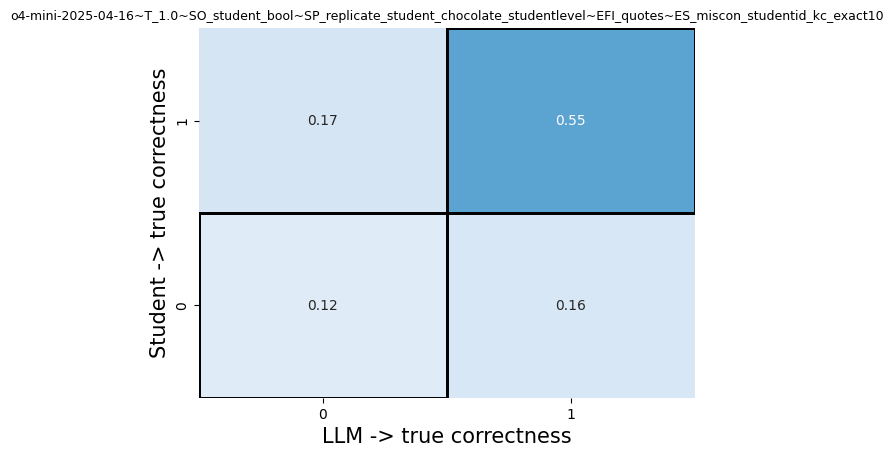

2025-08-11 08:21:26 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random10 run_id=1 split=val


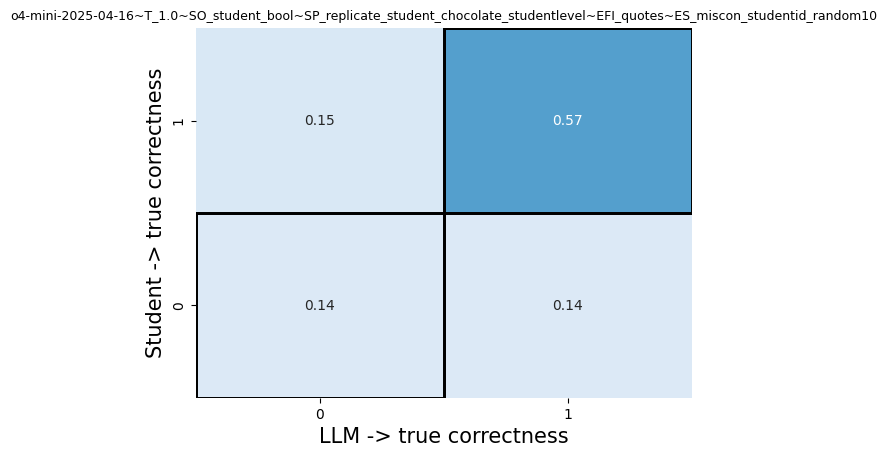

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact5 run_id=1 split=val


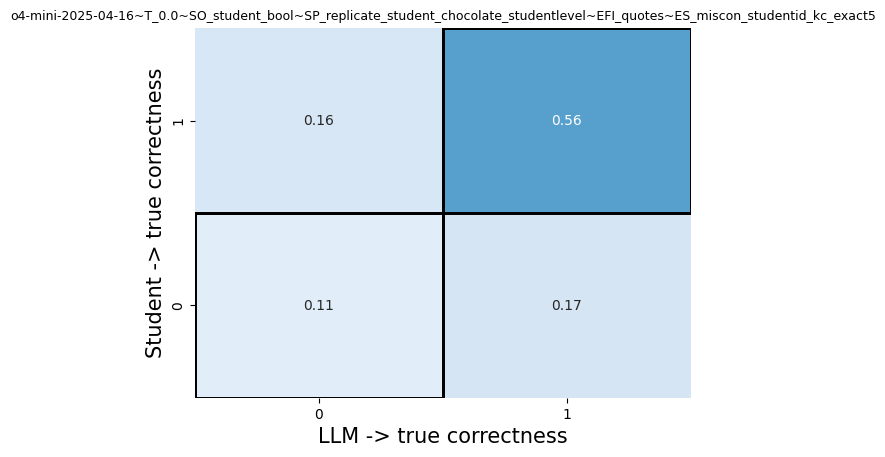

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random5 run_id=1 split=val


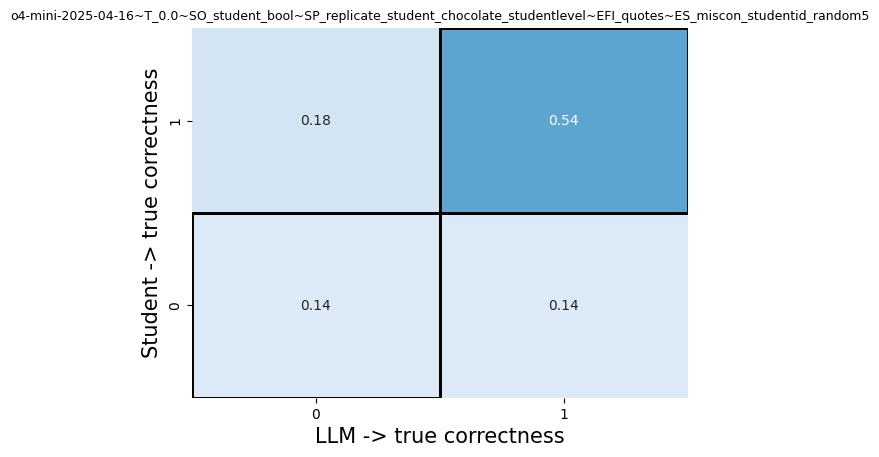

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random1 run_id=1 split=val


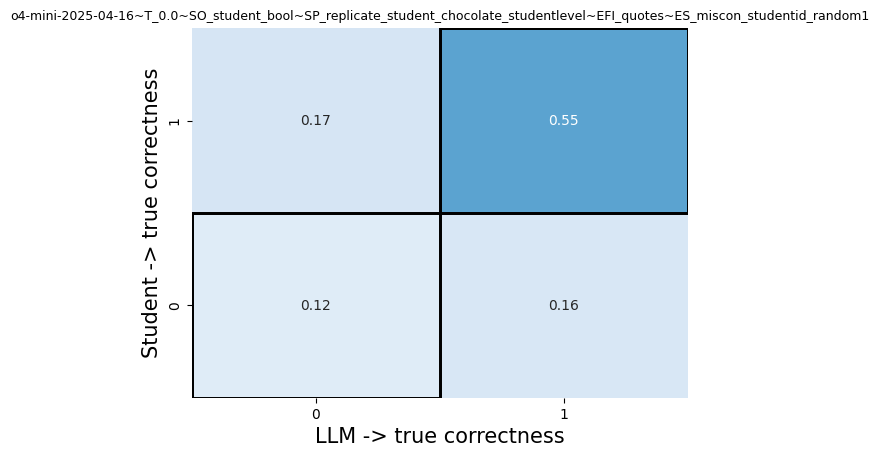

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact5 run_id=1 split=val


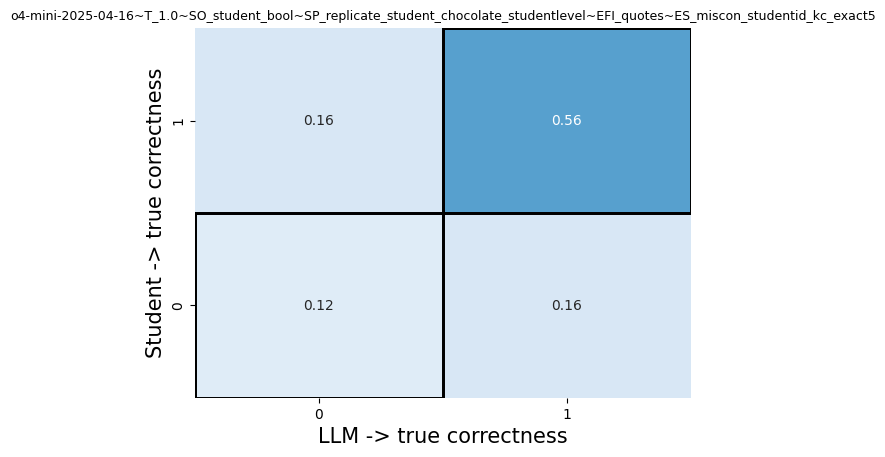

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random1 run_id=1 split=val


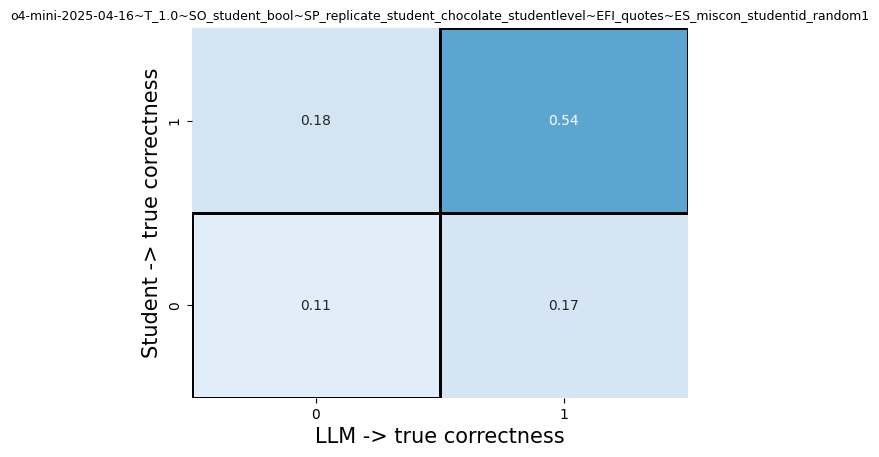

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact1 run_id=1 split=val


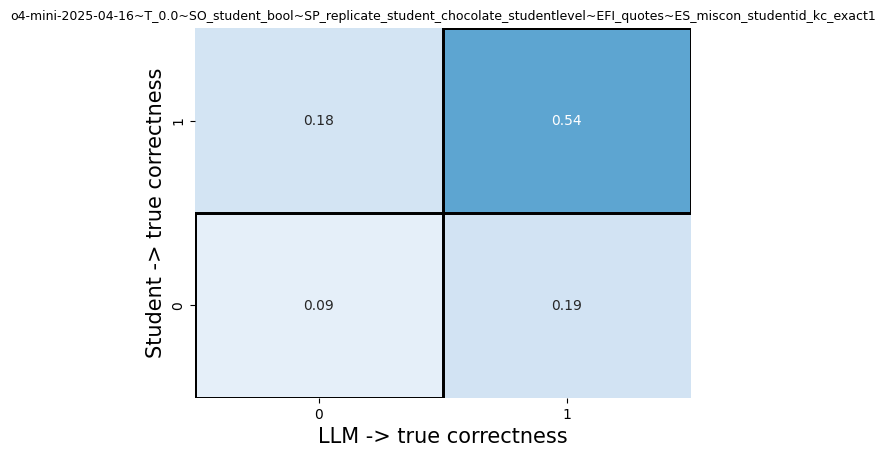

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact3 run_id=1 split=val


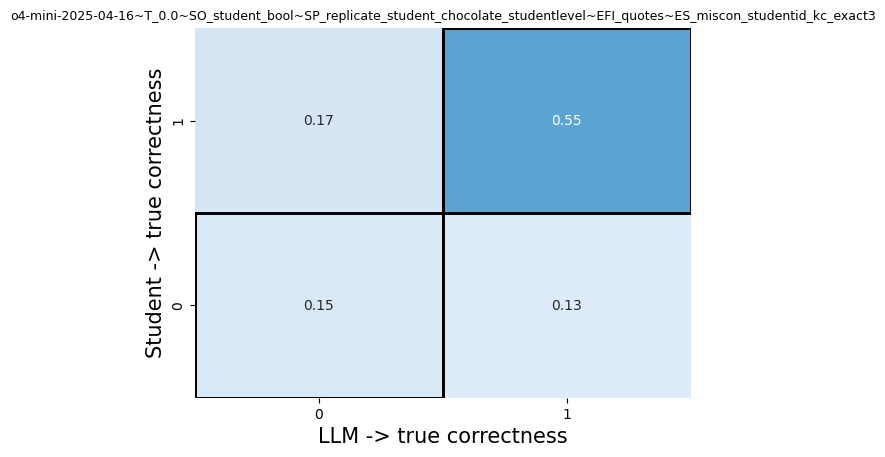

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact1 run_id=1 split=val


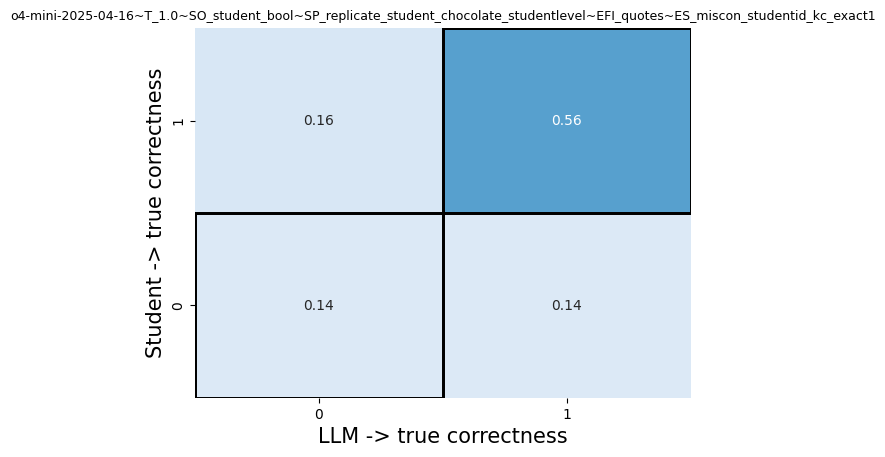

2025-08-11 08:21:27 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random3 run_id=1 split=val


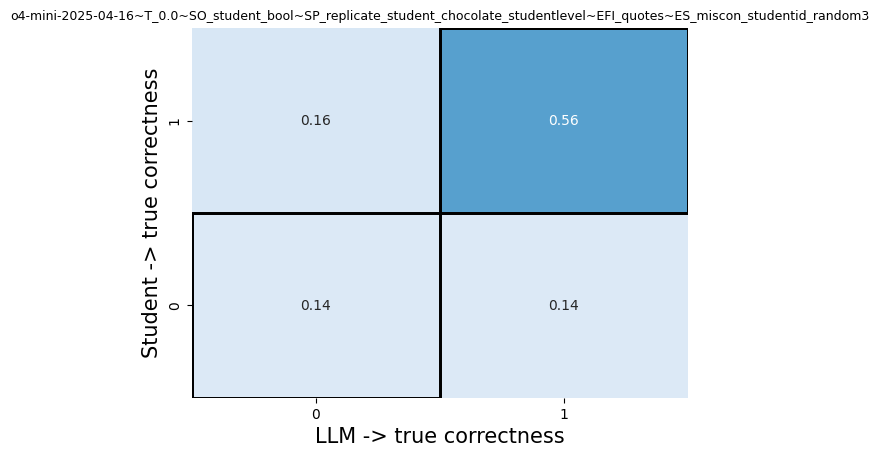

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random5 run_id=1 split=val


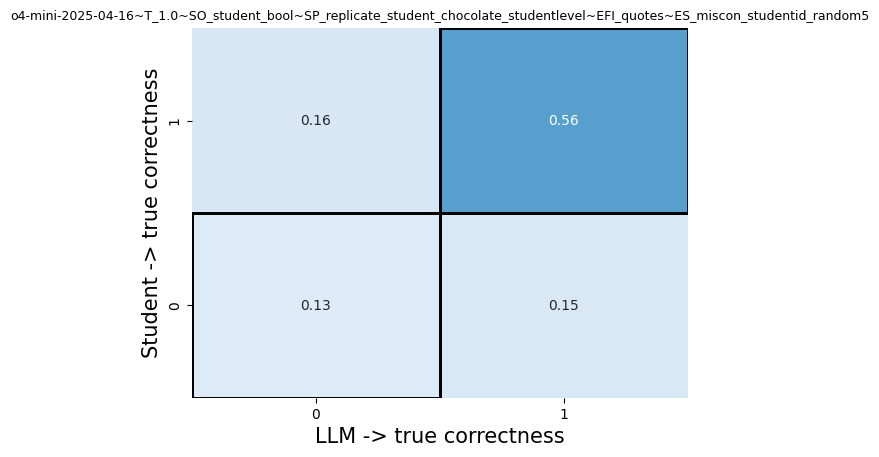

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random10 run_id=1 split=val


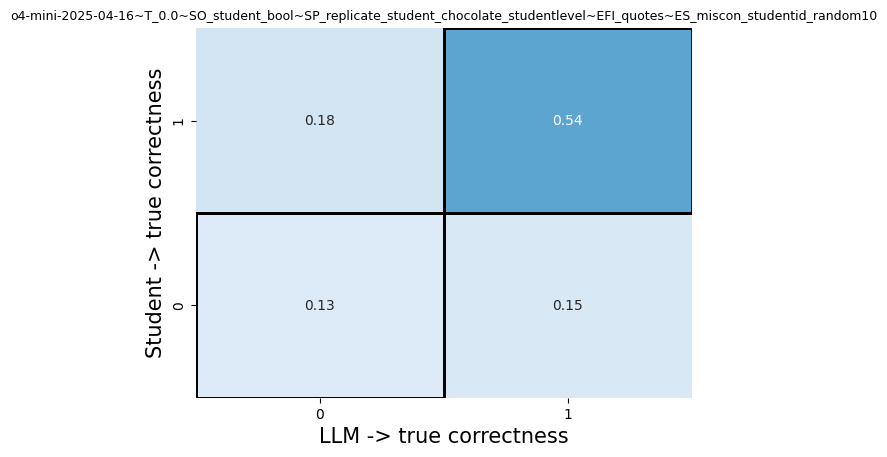

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_zero_studentlevel~EFI_quotes~ES_miscon_studentid_random0 run_id=1 split=val


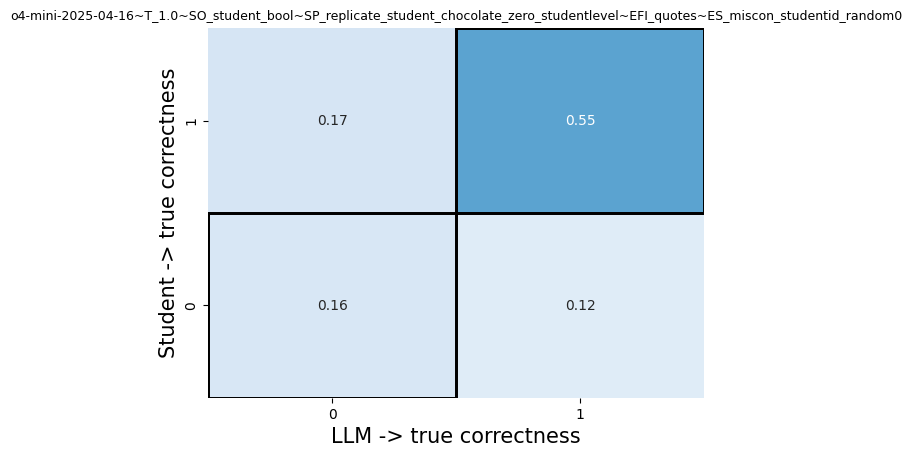

In [16]:
# all configs
for config_id in config_ids:
    preds_dict = get_llm_student_preds(
        exp_name=EXP_NAME,
        config_id=config_id,
        run_id=1,
        split="val",
    )
    plot_kt_confusion(
        preds_dict,
        config_id=config_id,
        normalize="all",
    )

# Student levels

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random3 run_id=1 split=val


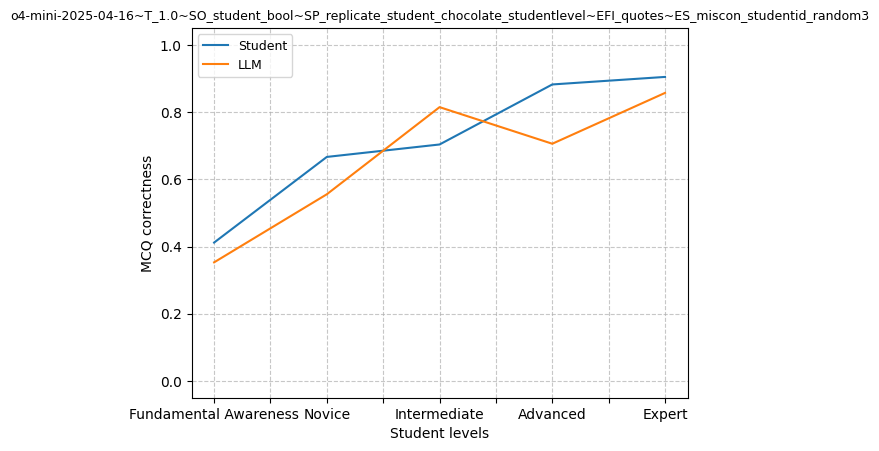

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact3 run_id=1 split=val


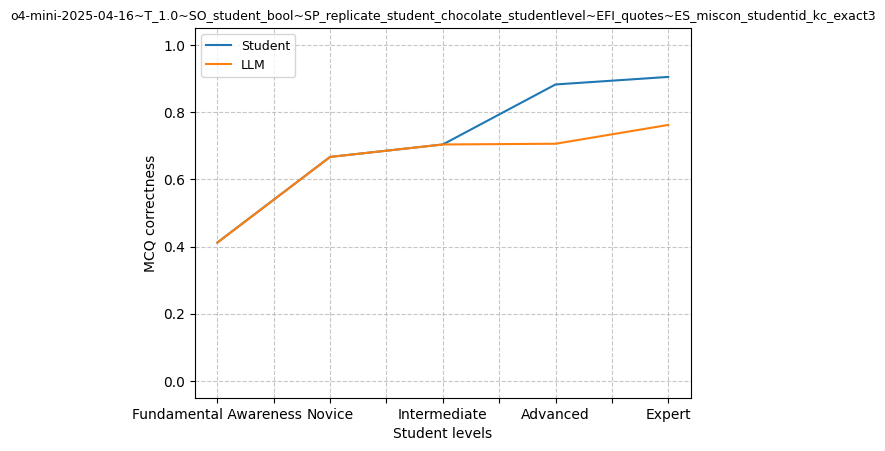

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact10 run_id=1 split=val


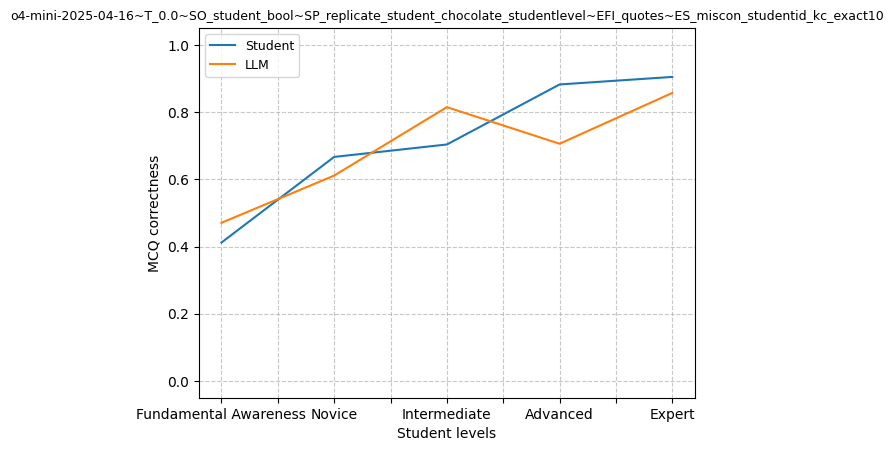

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_zero_studentlevel~EFI_quotes~ES_miscon_studentid_random0 run_id=1 split=val


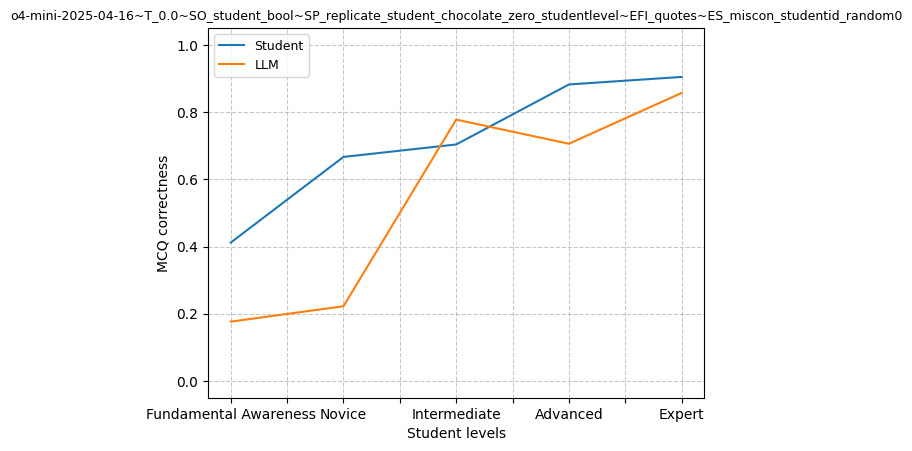

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact10 run_id=1 split=val


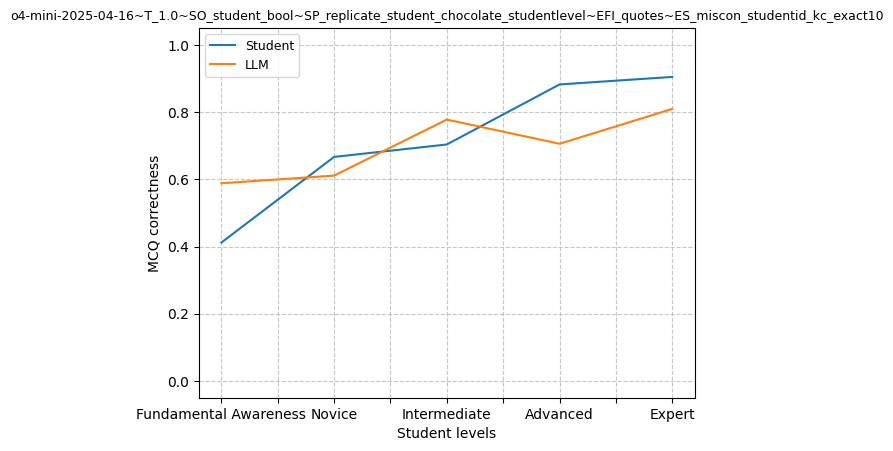

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random10 run_id=1 split=val


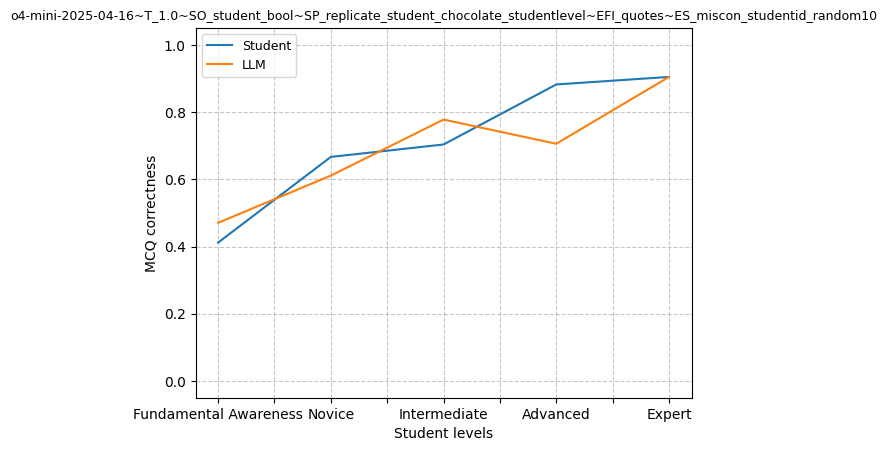

2025-08-11 08:21:28 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact5 run_id=1 split=val


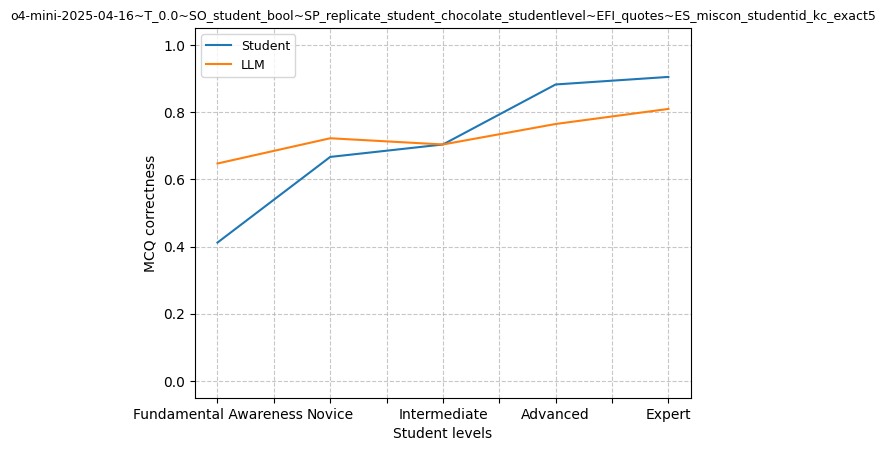

2025-08-11 08:21:29 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random5 run_id=1 split=val


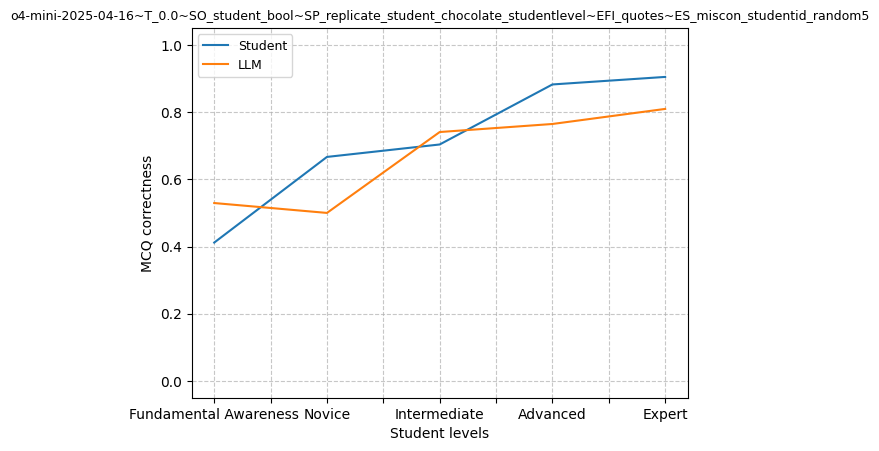

2025-08-11 08:21:29 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random1 run_id=1 split=val


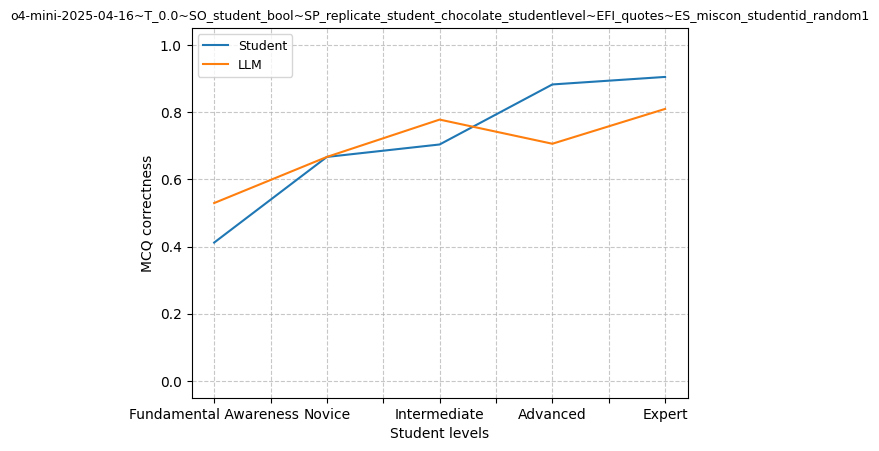

2025-08-11 08:21:29 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact5 run_id=1 split=val


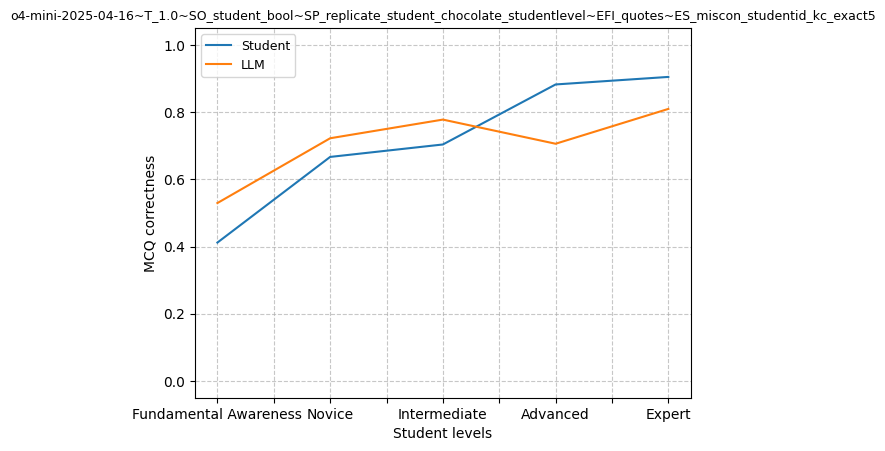

2025-08-11 08:21:29 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random1 run_id=1 split=val


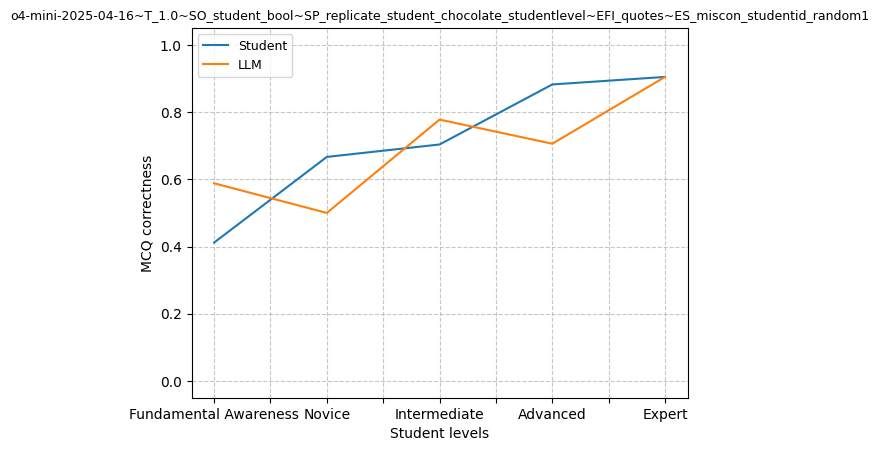

2025-08-11 08:21:29 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact1 run_id=1 split=val


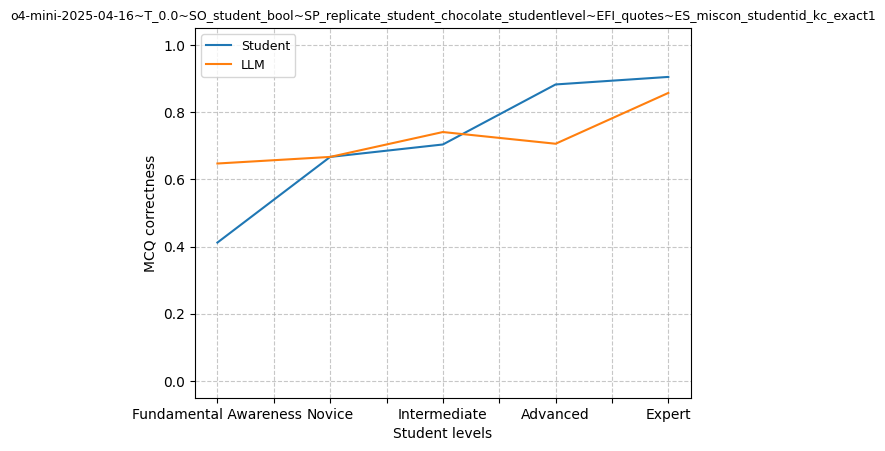

2025-08-11 08:21:29 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact3 run_id=1 split=val


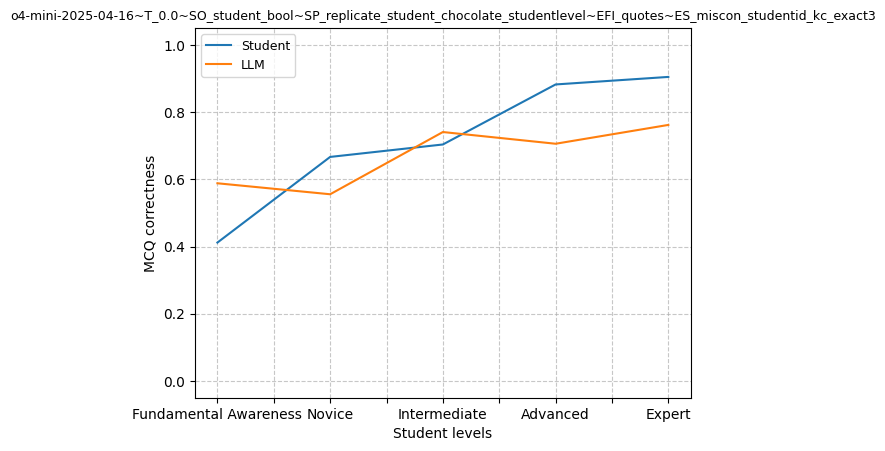

2025-08-11 08:21:30 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_kc_exact1 run_id=1 split=val


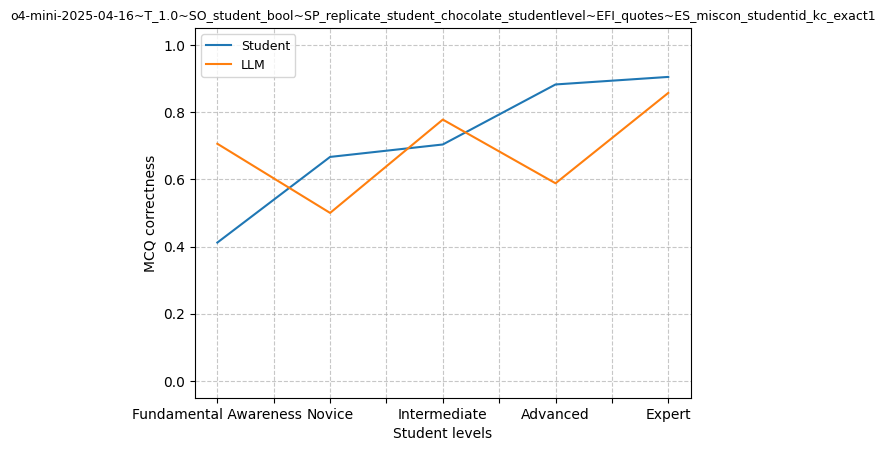

2025-08-11 08:21:30 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random3 run_id=1 split=val


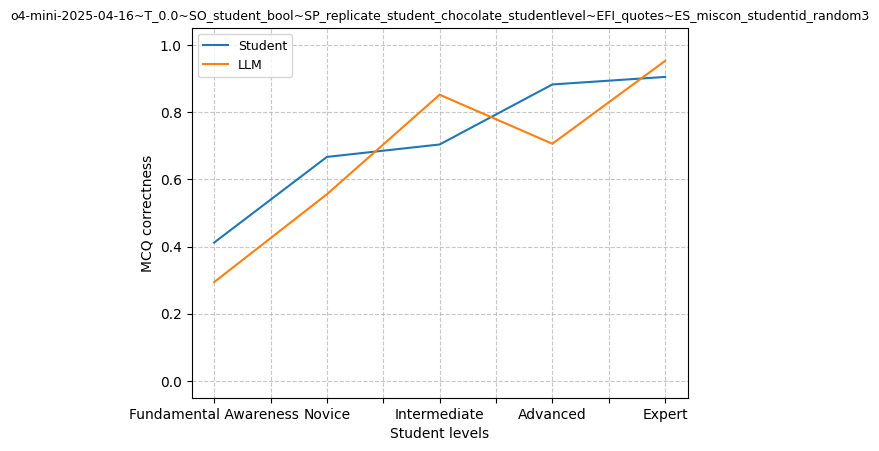

2025-08-11 08:21:30 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random5 run_id=1 split=val


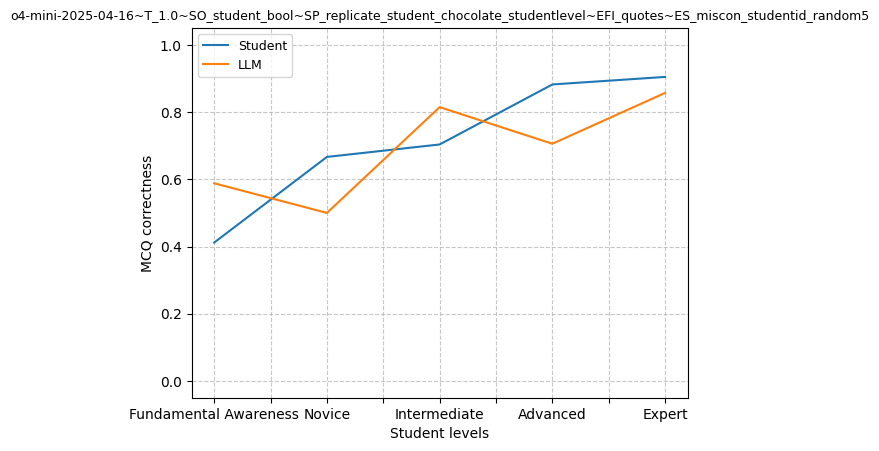

2025-08-11 08:21:30 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_0.0~SO_student_bool~SP_replicate_student_chocolate_studentlevel~EFI_quotes~ES_miscon_studentid_random10 run_id=1 split=val


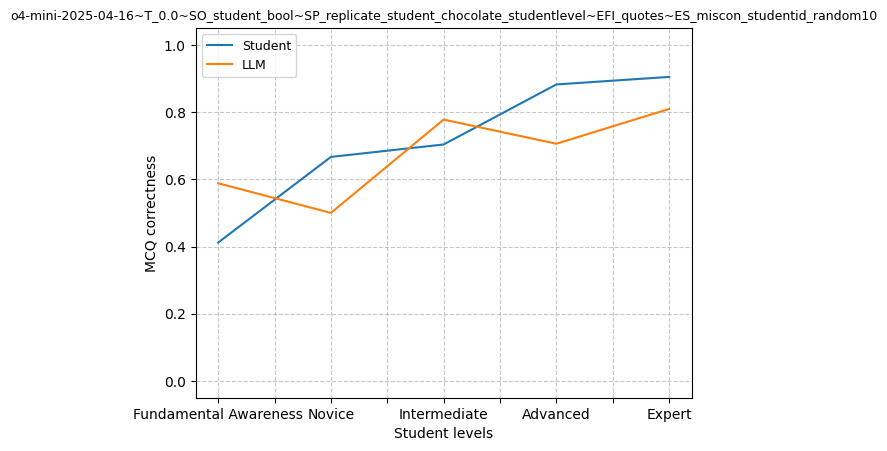

2025-08-11 08:21:30 [info     ] Reading predictions            config_id=o4-mini-2025-04-16~T_1.0~SO_student_bool~SP_replicate_student_chocolate_zero_studentlevel~EFI_quotes~ES_miscon_studentid_random0 run_id=1 split=val


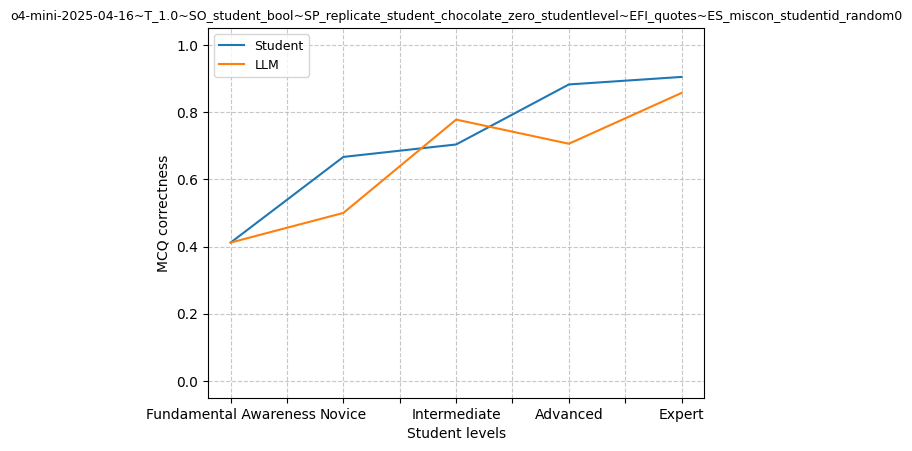

In [17]:
# all configs
for config_id in config_ids:
    preds_dict = get_llm_student_preds(
        exp_name=EXP_NAME,
        config_id=config_id,
        run_id=1,
        split="val",
    )
    plot_level_correctness(
        preds_dict,
        config_id=config_id,
    )